In [1]:
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt
import tabulate

In [ ]:
# Setup plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Connect to DuckDB
con = duckdb.connect()

# So that we can query as if it was a table in a DB 
con.execute(
    "CREATE OR REPLACE VIEW gold_data AS SELECT * FROM '../data/gold/daily_stats.parquet'"
)

print("Total Rows:", con.execute("SELECT COUNT(*) FROM gold_data").fetchone()[0])

# con.execute("DESCRIBE gold_data").df()

Total Rows: 221888


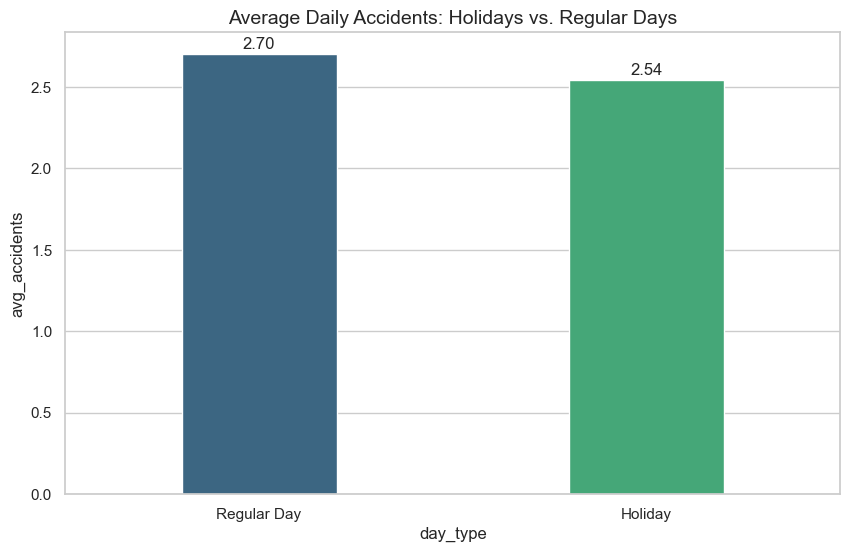

In [ ]:
sql_holiday = """
    SELECT 
        CASE 
            WHEN holiday_name != 'Non-Holiday' THEN 'Holiday'
            ELSE 'Regular Day' 
        END AS day_type,
        AVG(total_accidents) AS avg_accidents,
        AVG(number_of_persons_injured) AS avg_injuries
    FROM gold_data
    GROUP BY day_type
"""

df_holiday = con.execute(sql_holiday).fetchdf()

# Visualization
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=df_holiday,
    x='day_type',
    y='avg_accidents',
    hue='day_type',
    legend=False,
    palette='viridis',
    width=0.4,
    dodge=False,
    ax=ax1
)
ax1.set_title("Average Daily Accidents: Holidays vs. Regular Days", fontsize=14)
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.2f', padding=2)
    
plt.show()

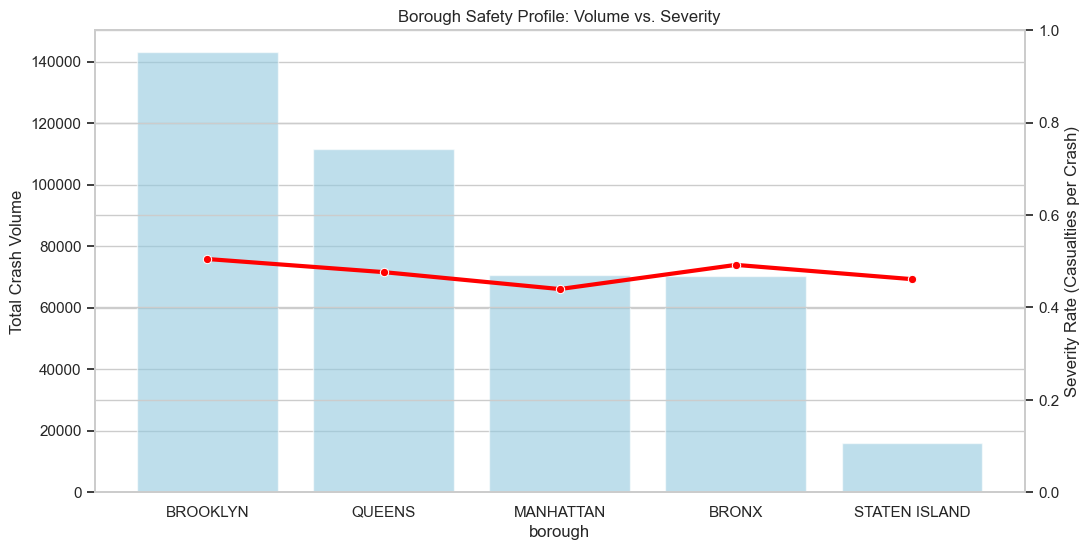

In [ ]:
sql_borough = """
    SELECT 
        borough,
        SUM(total_accidents) AS total_crashes,
        -- Calculate Severity: (Injured + Killed) / Total Crashes
        (SUM(number_of_persons_injured) + SUM(number_of_persons_killed)) / CAST(SUM(total_accidents) AS FLOAT) AS severity_rate
    FROM gold_data
    WHERE borough != 'UNKNOWN'
    GROUP BY borough
    ORDER BY total_crashes DESC
"""

df_borough = con.execute(sql_borough).fetchdf()

# Visualization
fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(data=df_borough, x='borough', y='total_crashes', color='skyblue', ax=ax1, alpha=0.6)
ax1.set_ylabel('Total Crash Volume')

ax2 = ax1.twinx()
sns.lineplot(data=df_borough, x='borough', y='severity_rate', color='red', marker='o', ax=ax2, linewidth=3)
ax2.set_ylabel('Severity Rate (Casualties per Crash)')
ax2.set_ylim(0, 1)

plt.title("Borough Safety Profile: Volume vs. Severity")
plt.show()

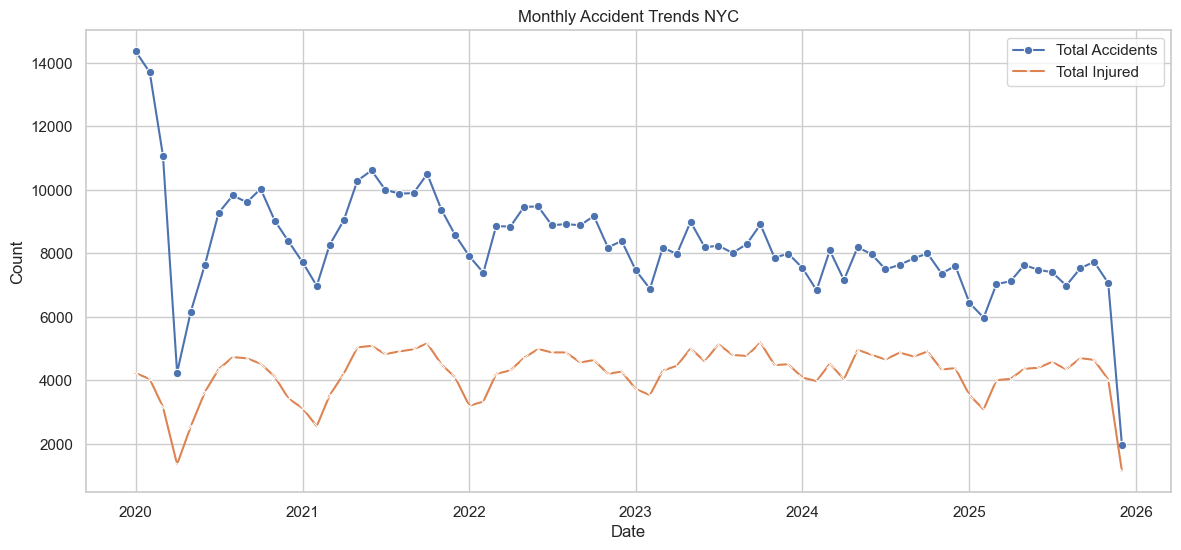

In [5]:
sql_trend = """
    SELECT 
        date_trunc('month', date) AS month_start,
        SUM(total_accidents) AS total_accidents,
        SUM(number_of_persons_injured) AS total_injured
    FROM gold_data
    GROUP BY month_start
    ORDER BY month_start
"""

df_trend = con.execute(sql_trend).fetchdf()

# Visualization
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_trend, x='month_start', y='total_accidents', marker='o', label='Total Accidents')
sns.lineplot(data=df_trend, x='month_start', y='total_injured', marker='x', label='Total Injured')

plt.title("Monthly Accident Trends NYC")
plt.ylabel("Count")
plt.xlabel("Date")
plt.show()

In [6]:
sql_dangerous_holidays = """
    SELECT 
        holiday_name,
        AVG(total_accidents) as avg_accidents
    FROM gold_data
    WHERE holiday_name != 'Non-Holiday'
    GROUP BY holiday_name
    HAVING COUNT(*) > 1 -- Filter out one-off holidays
    ORDER BY avg_accidents DESC
    LIMIT 5
"""

df_top5 = con.execute(sql_dangerous_holidays).fetchdf()

print("🚨 TOP 5 MOST DANGEROUS HOLIDAYS IN NYC 🚨")
print(df_top5.to_markdown(index=False))

🚨 TOP 5 MOST DANGEROUS HOLIDAYS IN NYC 🚨
| holiday_name                         |   avg_accidents |
|:-------------------------------------|----------------:|
| Labour Day                           |         2.71477 |
| Lincoln's Birthday                   |         2.70875 |
| Juneteenth National Independence Day |         2.68774 |
| New Year's Day                       |         2.64928 |
| Truman Day                           |         2.56444 |


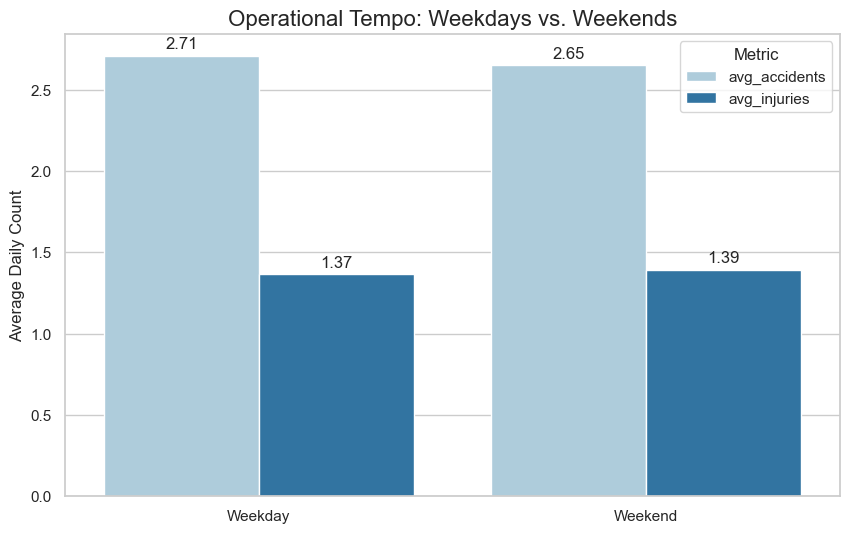

In [ ]:
sql_weekend = """
    SELECT 
        CASE 
            WHEN is_weekend = true THEN 'Weekend' 
            ELSE 'Weekday' 
        END AS day_type,
        AVG(total_accidents) AS avg_accidents,
        AVG(number_of_persons_injured) AS avg_injuries,
        -- Calculate severity per day type
        SUM(number_of_persons_injured + number_of_persons_killed) / SUM(total_accidents) as severity_rate
    FROM gold_data
    GROUP BY day_type
"""

df_weekend = con.execute(sql_weekend).fetchdf()

# Visualization
df_weekend_melt = df_weekend.melt(
    id_vars=['day_type'], 
    value_vars=['avg_accidents', 'avg_injuries'],
    var_name='Metric', 
    value_name='Count'
)

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(
    data=df_weekend_melt, 
    x='day_type', 
    y='Count', 
    hue='Metric', 
    palette='Paired',
    ax=ax
)

ax.set_title("Operational Tempo: Weekdays vs. Weekends", fontsize=16)
ax.set_ylabel("Average Daily Count")
ax.set_xlabel("")

# Add labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.show()

┌─────────────────────┬─────────────────┬────────────────┬─────────────────┐
│ weather_condition   │   avg_accidents │   avg_injuries │   days_observed │
├─────────────────────┼─────────────────┼────────────────┼─────────────────┤
│ Fog                 │             2.8 │            1.4 │           15071 │
│ Rain                │             2.7 │            1.4 │           71443 │
│ Snow                │             2.7 │            1.1 │            4490 │
│ Clear               │             2.7 │            1.4 │          130884 │
└─────────────────────┴─────────────────┴────────────────┴─────────────────┘


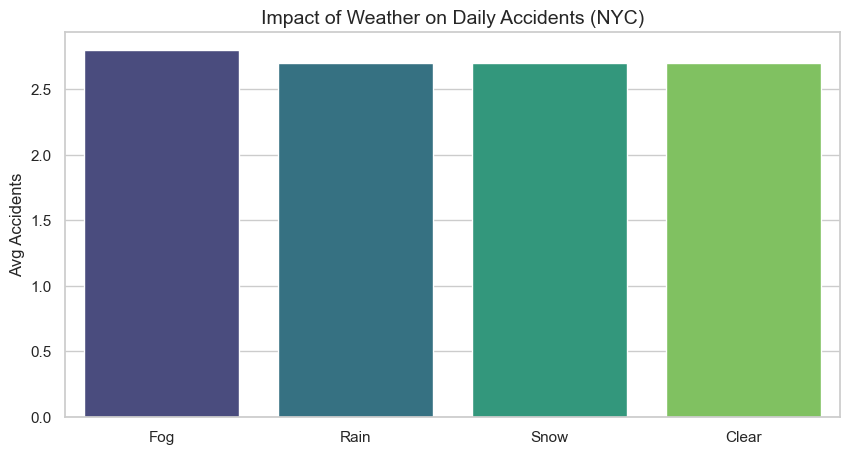

In [8]:
sql_weather = """
    SELECT 
        CASE 
            WHEN has_snow = true THEN 'Snow' 
            WHEN has_rain = true THEN 'Rain' 
            WHEN is_foggy = true THEN 'Fog' 
            ELSE 'Clear' 
        END AS weather_condition,
        ROUND(AVG(total_accidents), 1) as avg_accidents,
        ROUND(AVG(number_of_persons_injured), 1) as avg_injuries,
        COUNT(*) as days_observed
    FROM gold_data
    GROUP BY 1
    ORDER BY avg_accidents DESC
"""

df_weather = con.execute(sql_weather).fetchdf()

# Results
print(tabulate.tabulate(df_weather, headers='keys', tablefmt='simple_outline', showindex=False))

# Visualization
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=df_weather, 
    x='weather_condition', 
    y='avg_accidents', 
    hue='weather_condition', 
    legend=False,
    palette='viridis'
)

plt.title("Impact of Weather on Daily Accidents (NYC)", fontsize=14)
plt.ylabel("Avg Accidents")
plt.xlabel("") # Remove redundant label
plt.show()